Correct data for background and save the results as an extra layer in the anndata object:

Load relevant packages and data:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import diffxpy.api as de
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [3]:
adata_wta = pickle.load(open(path + "data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In [4]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

Fit seperate model to each slide:

In [5]:
slides = np.array(('00MR', '00MU', ('00MV', '00MV-2'), '00MW'))
adata_slide = list()
for j in range(len(slides)):
    adata_slide.append(adata_wta[[adata_wta.obs['slide'][i] in slides[j] for i in range(len(adata_wta.obs['slide']))]])
    print(np.shape(adata_slide[j]))

(66, 18454)
(74, 18454)
(52, 18454)
(63, 18454)


In [6]:
counts_geneProbes = list()
counts_negativeProbes = list()

for i in range(len(slides)):
    counts_geneProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var != 'NegProbe-WTX').squeeze()].X))
    counts_negativeProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var =='NegProbe-WTX').squeeze()].X))

In [7]:
models = list()
for i in range(len(slides)):
    models.append(ProbeCounts_GeneralModel_V1(
        X_data = counts_geneProbes[i],
        Y_data = counts_negativeProbes[i],
        var_names = adata_wta.var_names[adata_wta.var_names != 'NegProbe-WTX'],
        n_factors = 30))

INFO (theano.gof.compilelock): Waiting for existing lock by process '38700' (I am process '60857')
INFO (theano.gof.compilelock): To manually release the lock, delete /nfs/users/nfs_a/aa16/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir


Fitting for slide:  00MR


Average Loss = 4.7736e+06: 100%|██████████| 100000/100000 [1:16:00<00:00, 21.93it/s]
Finished [100%]: Average Loss = 4.7736e+06


Fitting for slide:  00MU


Average Loss = 5.493e+06: 100%|██████████| 100000/100000 [1:16:34<00:00, 21.76it/s]
Finished [100%]: Average Loss = 5.493e+06


Fitting for slide:  ('00MV', '00MV-2')


Average Loss = 4.0827e+06: 100%|██████████| 100000/100000 [1:15:08<00:00, 22.18it/s]
Finished [100%]: Average Loss = 4.0827e+06


Fitting for slide:  00MW


Average Loss = 4.6149e+06: 100%|██████████| 100000/100000 [1:15:57<00:00, 21.94it/s]
Finished [100%]: Average Loss = 4.6149e+06


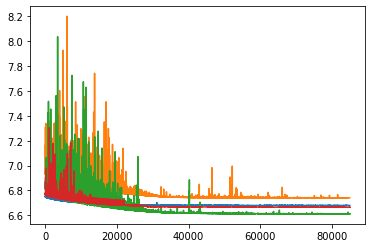

In [8]:
total_iterations = 10**5
for i in range(len(slides)):
    print('Fitting for slide: ', slides[i])
    models[i].fit_advi_iterative(n_iter = total_iterations, learning_rate = 0.001, n=1, method='advi')

Show training history:

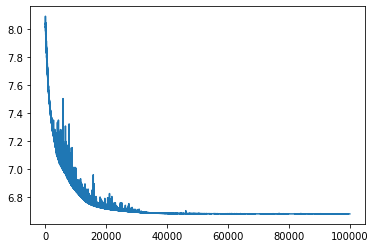

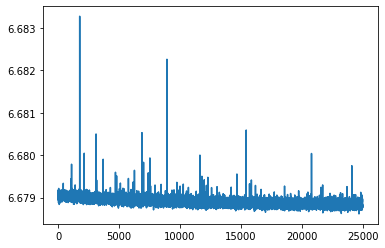

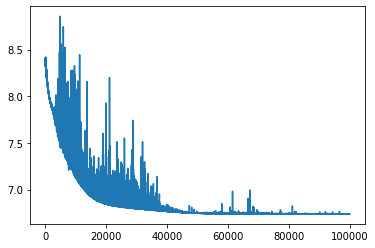

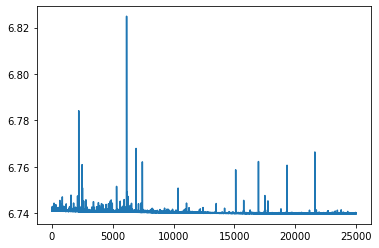

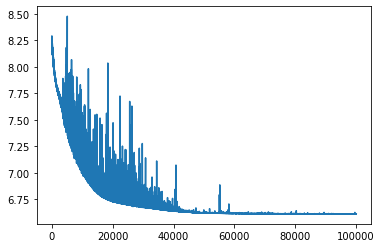

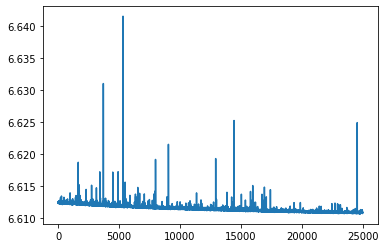

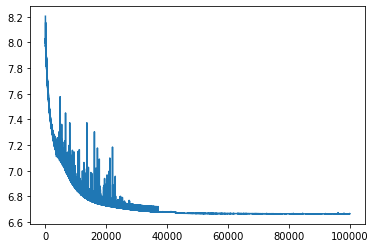

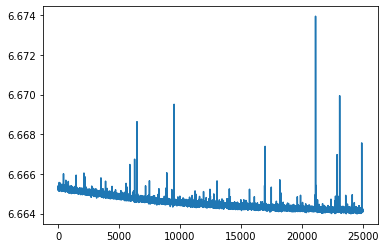

In [13]:
for i in range(len(slides)):
    models[i].plot_history()
    plt.show()
    models[i].plot_history(75000)
    plt.show()

Sample posterior:

In [22]:
for i in range(len(slides)):
    print(slides[i])
    models[i].sample_posterior(node='all', n_samples=1000, save_samples=False);

00MR
00MU
('00MV', '00MV-2')
00MW


Compute X_corrected and save results into anndata object:

In [23]:
for i in range(len(slides)):
    ProbeCounts_GeneralModel_V1.compute_X_corrected(models[i])

In [24]:
adata_wta.layers['X_Corrected'] = adata_wta.X
for j in range(len(slides)):
    subset_cells = [adata_wta.obs['slide'][i] in slides[j] for i in range(len(adata_wta.obs['slide']))]
    subset_genes = [adata_wta.var_names[i] in models[j].var_names for i in range(len(adata_wta.var_names))]
    adata_wta.layers['X_Corrected'][subset_cells, :][:, subset_genes] = models[j].X_corrected_mean

In [29]:
adata_wta.obs['TotalCounts_corrected'] = np.sum(adata_wta.layers['X_Corrected'], axis = 1)
adata_wta.layers['CPM_corrected'] = np.asarray([adata_wta.layers['X_Corrected'][i,:]/adata_wta.obs['TotalCounts_corrected'][i] for i in range(len(adata_wta.obs['TotalCounts_corrected']))])*10**6

In [30]:
adata_wta.layers['X'] = adata_wta.X

In [31]:
adata_wta.layers

Layers with keys: CPM, X_Corrected, CPM_corrected, X

In [34]:
pickle.dump(adata_wta, open("/nfs/team283/aa16/KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p", "wb" ))
pickle.dump(adata_wta, open("/nfs/team283/aa16/InSituCellTools/data/nanostringWTA_fetailBrain_AnnData.p", "wb" ))